In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

from SDT import SDT

In [3]:
def onehot_coding(target, device, output_dim):
    """Convert the class labels into one-hot encoded vectors."""
    target_onehot = torch.FloatTensor(target.size()[0], output_dim).to(device)
    target_onehot.data.zero_()
    target_onehot.scatter_(1, target.view(-1, 1), 1.0)
    return target_onehot


# Parameters
input_dim = 28 * 28    # the number of input dimensions
output_dim = 10        # the number of outputs (i.e., # classes on MNIST)
depth = 5              # tree depth
lamda = 1e-3           # coefficient of the regularization term 
weight_decaly = 5e-4   # weight decay
batch_size = 128       # batch size
epochs = 50            # the number of training epochs
log_interval = 100     # the number of batches to wait before printing logs
use_cuda = False       # whether to use GPU

# Model and Optimizer
tree = SDT(input_dim, output_dim, depth, lamda, use_cuda)

# Load data
data_dir = "datasets/stl10_binary"

transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir,
                    train=True,
                    download=True,
                    transform=transformer),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_dir,
                    train=False,
                    transform=transformer),
    batch_size=batch_size,
    shuffle=True,
)

device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
tree.load_state_dict(torch.load('saved_models/tree_state_dict.pth'))
tree.eval()

SDT(
  (inner_nodes): Sequential(
    (0): Linear(in_features=785, out_features=31, bias=False)
    (1): Sigmoid()
  )
  (leaf_nodes): Linear(in_features=32, out_features=10, bias=False)
)

[[-4.0875972e-04 -4.0708919e-04 -4.0823306e-04 ... -4.0818230e-04
  -4.0635094e-04 -4.0620277e-04]
 [-3.8546088e-05 -3.3971584e-05 -3.8170394e-05 ... -3.8264392e-05
  -3.8044225e-05 -3.6338250e-05]
 [ 1.4169811e-04  1.4166415e-04  1.4166818e-04 ...  1.4166425e-04
   1.4169182e-04  1.4169703e-04]
 ...
 [-1.2267955e-03 -1.2210525e-03 -1.2230338e-03 ... -1.2216570e-03
  -1.2134194e-03 -1.2146940e-03]
 [ 2.6601416e-03  2.5653825e-03  2.6493589e-03 ...  2.6375195e-03
   2.5724568e-03  2.5723507e-03]
 [-2.4523640e-03 -2.2000091e-03 -2.4340036e-03 ... -2.4323675e-03
  -2.4084377e-03 -2.3204843e-03]]


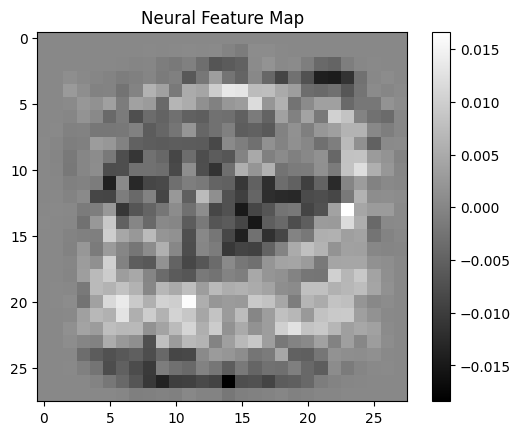

In [4]:
# Load a batch of data from the test_loader or train_loader
data_iter = iter(test_loader)
X, _ = next(data_iter)  # Only fetch the inputs (ignore the targets)

# Move the data to the correct device
# Flatten the images and move to the device
X = X.view(-1, input_dim).to(device)

# Compute the Neural Feature Map for this batch of data
nfm = tree.compute_nfm(X)

# Now `nfm` contains the feature importances, which you can print or analyze further
print(nfm)

# For example, you could visualize the average NFM across all features

# Assuming nfm is a 2D array where the first dimension is the batch size
avg_nfm = nfm.mean(axis=0)  # Average over all samples in the batch

# Reshape to the original image size if necessary (e.g., for MNIST 28x28)
avg_nfm = avg_nfm.reshape(28, 28)

# Plot the average NFM
plt.imshow(avg_nfm, cmap='grey', interpolation='nearest')
plt.colorbar()
plt.title('Neural Feature Map')
plt.show()

In [11]:
tree.inner_nodes[0]

Linear(in_features=785, out_features=31, bias=False)

In [26]:
weights = tree.inner_nodes[0].weight.data.cpu().numpy()
weights = weights[:, :-1]

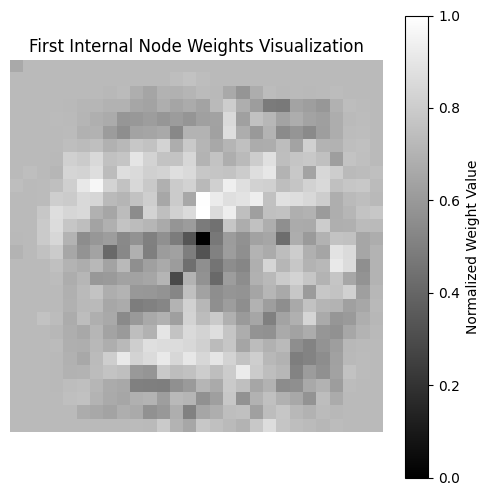

In [30]:
# Select weights for the first internal node
first_node_weights = weights[2, :]

# Normalize weights to the range [0, 1] for grayscale visualization
min_weight = np.min(first_node_weights)
max_weight = np.max(first_node_weights)
normalized_weights = (first_node_weights - min_weight) / \
    (max_weight - min_weight)

# Reshape weights for visualization
# The reshape dimensions depend on the number of features; here, we're assuming a square shape for simplicity
# Calculate dimension size to attempt a square shape
dim = int(np.ceil(np.sqrt(len(normalized_weights))))
image_shape = np.zeros((dim, dim))  # Create a base image with zeros
# Fill the image with weights
image_shape = normalized_weights.reshape((28, 28))

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(image_shape, cmap='gray', interpolation='nearest')
plt.colorbar(label='Normalized Weight Value')
plt.title('First Internal Node Weights Visualization')
plt.axis('off')  # Optionally remove the axis
plt.show()

In [2]:
from dataset import get_stl_star

In [3]:
device = torch.device("cuda" if True and torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader = get_stl_star(data_dir='datasets', batch_size=128)

# Initialize model
tree = SDT(96 * 96 * 3, 2, 5, 1e-3, True).to(device)

Files already downloaded and verified
Files already downloaded and verified
Num Train:  800 Num Val:  200 Num Test:  1600


In [4]:
tree.load_state_dict(torch.load('stl_star_model.pth'))
tree.eval()

SDT(
  (inner_nodes): Sequential(
    (0): Linear(in_features=27649, out_features=31, bias=False)
    (1): Sigmoid()
  )
  (leaf_nodes): Linear(in_features=32, out_features=2, bias=False)
)

In [5]:
input_dim = 96 * 96 * 3

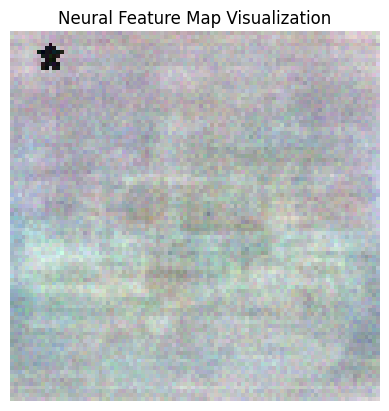

In [13]:
# Load a batch of data from the test_loader or train_loader
data_iter = iter(test_loader)
X, _ = next(data_iter)  # Only fetch the inputs (ignore the targets)

# Move the data to the correct device
# Flatten the images and move to the device
X = X.view(-1, input_dim).to(device)

# Compute the Neural Feature Map for this batch of data
nfm = tree.compute_nfm(X)

avg_nfm = nfm.mean(axis=0)  # Assuming nfm is a PyTorch tensor

# Extract the diagonal of avg_nfm
# Ensure it's on CPU and convert to NumPy for manipulation

# Assuming diagonal has the correct length (96*96*3)
# Split the diagonal into thirds for RGB channels
third_length = len(avg_nfm) // 3
red_channel = avg_nfm[:third_length].reshape(96, 96)
green_channel = avg_nfm[third_length:2*third_length].reshape(96, 96)
blue_channel = avg_nfm[2*third_length:3*third_length].reshape(96, 96)

# Stack the channels to form a 3-channel (RGB) image
rgb_image = np.stack([red_channel, green_channel, blue_channel], axis=-1)

# Normalize the image to [0, 1] for plotting
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

# Plot the RGB image
plt.imshow(rgb_image, interpolation='nearest')
plt.title('Neural Feature Map Visualization')
plt.axis('off')  # Hide axis for better visualization
plt.show()